In [1]:
import jupyter_black

jupyter_black.load()

Weights validated - sum: 1.0


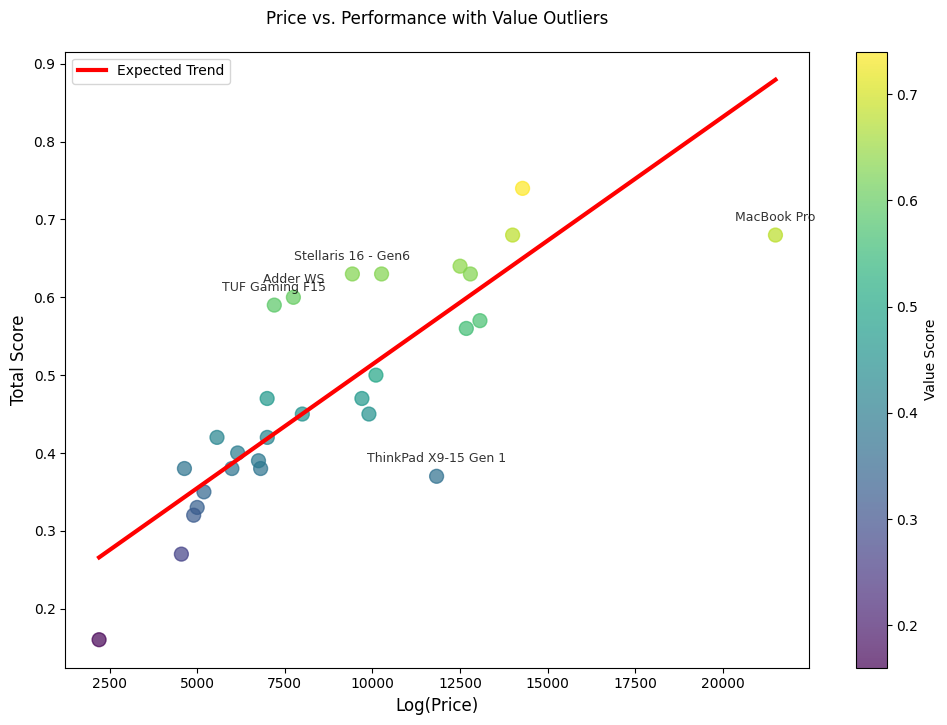

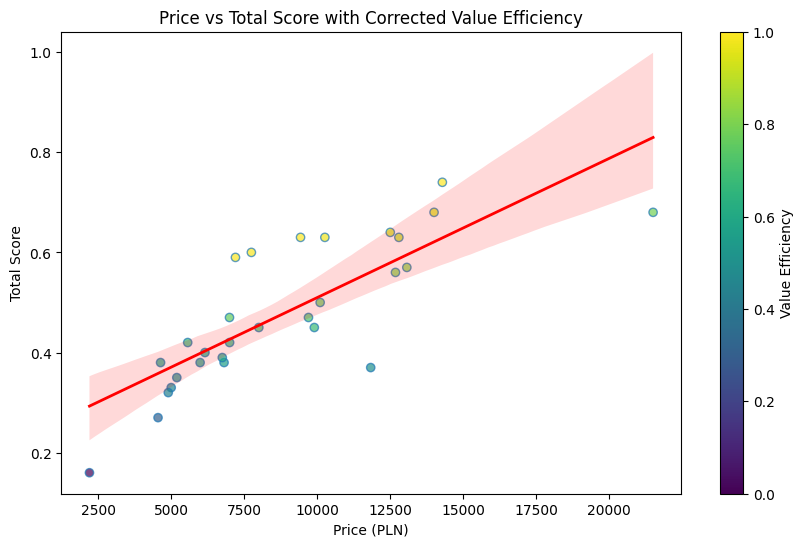

,Rank,Laptop Name,Price,Total Score,Value Efficiency,Final Score
27,1,TUF Gaming F15,7199.00,0.59,0.989014,0.767506
12,2,Adder WS,7744.00,0.60,0.992105,0.765648
25,3,Stellaris 16 - Gen6,9427.46,0.63,0.995448,0.759060
23,4,NEO 16,14283.00,0.74,1.000000,0.757883
16,5,HoMei,10260.00,0.63,0.972846,0.740333


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import HuberRegressor
import plotly.express as px
import seaborn as sns

# Set display options
pd.set_option("display.max_columns", None)

# Define system score mapping and feature configuration
SYSTEM_SCORE = {"Windows": 0, "MacOS": 0.5, "Linux": 1, "NoOS": 1}
FEATURES = [
    {"name": "CPU Performance", "weight": 0.20, "invert": False},
    {"name": "GPU Performance", "weight": 0.20, "invert": False},
    {"name": "RAM", "weight": 0.15, "invert": False},
    {"name": "Effective VRAM", "weight": 0.15, "invert": False},
    {"name": "New", "weight": 0.09, "invert": False},
    {"name": "Storage", "weight": 0.05, "invert": False},
    {"name": "System", "weight": 0.04, "invert": False},
    {"name": "Weight", "weight": 0.04, "invert": True},
    {"name": "Resolution", "weight": 0.04, "invert": False},
    {"name": "Temperature", "weight": 0.02, "invert": True},
    {"name": "Brand Reliability", "weight": 0.02, "invert": True},
]

print("Weights validated - sum:", sum(f["weight"] for f in FEATURES))


def load_and_clean_data(filepath: str) -> pd.DataFrame:
    raw = pd.read_csv(filepath)
    data = pd.DataFrame()
    data["Laptop Name"] = raw["Laptop Name"]
    data["Brand Reliability"] = (
        raw["Brand Reliability"].str.replace("%", "").astype(float) / 100
    )

    numeric_cols = [
        "CPU Performance",
        "GPU Performance",
        "RAM",
        "VRAM",
        "Screen Size",
        "Resolution",
        "Weight",
        "Storage",
        "Temperature",
        "New",
        "Price",
    ]
    for new_col in numeric_cols:
        data[new_col] = pd.to_numeric(raw[new_col], errors="coerce")
    data["System"] = raw["System"]
    data["GPU"] = raw["GPU"].str.lower()

    # Return data with NaN values to allow for better imputation later if needed
    return data


# Load the data
data = load_and_clean_data("laptops.csv")
data.head()


def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    def get_gpu_type(gpu_name):
        gpu_name = str(gpu_name).lower()
        if any(
            kw in gpu_name
            for kw in ["nvidia", "rtx", "gtx", "3070", "3080", "mx250", "7700s"]
        ):
            return "Dedicated"
        if any(kw in gpu_name for kw in ["apple m", "m1", "m2", "m3", "m4"]):
            return "Unified"
        return "Integrated"

    data["GPU Type"] = data["GPU"].apply(get_gpu_type)

    # Calculate Effective VRAM based on GPU type
    vram_rules = {
        "Dedicated": lambda df: df["VRAM"] + 0.5 * df["RAM"],
        "Integrated": lambda df: df["RAM"] * 0.5,
        "Unified": lambda df: df["RAM"] * 0.8,
    }
    for gpu_type, formula in vram_rules.items():
        mask = data["GPU Type"] == gpu_type
        data.loc[mask, "Effective VRAM"] = formula(data.loc[mask])

    # Map the system scores
    data["System Score"] = data["System"].map(SYSTEM_SCORE)

    return data


# Apply feature engineering
data = feature_engineering(data)
data


def compute_scores(data: pd.DataFrame) -> pd.DataFrame:
    # scaler = RobustScaler()

    # Process standard (non-inverted) features (excluding 'System' and 'New')
    standard_features = [
        f["name"]
        for f in FEATURES
        if not f["invert"] and f["name"] not in ["System", "New"]
    ]
    for col in standard_features:
        scaler = MinMaxScaler()

        data[f"{col} Score"] = scaler.fit_transform(data[[col]])
        data.loc[:, f"{col} Score"] = data[f"{col} Score"].fillna(
            data[f"{col} Score"].quantile(0.1)
        )

    # Process inverted features
    for feature in [f for f in FEATURES if f["invert"]]:
        scaler = MinMaxScaler()

        col = feature["name"]
        data[f"{col} Score"] = 1 - scaler.fit_transform(data[[col]])
        data.loc[:, f"{col} Score"] = data[f"{col} Score"].fillna(
            data[f"{col} Score"].quantile(0.1)
        )

    # Process 'New' and 'System' scores
    data["New Score"] = data["New"]
    data["System Score"] = data["System"].map(SYSTEM_SCORE)

    # Calculate Total Score
    data["Total Score"] = 0
    for feature in FEATURES:
        score_col = f"{feature['name']} Score"
        weight = feature["weight"]
        data["Total Score"] += data[score_col] * weight

    return data


# Compute scores
data = compute_scores(data)
data = data.round(2)
data

plt.figure(figsize=(12, 8))
ax = plt.gca()

scatter = ax.scatter(
    data["Price"],
    data["Total Score"],
    c=data["Total Score"],
    cmap="viridis",
    alpha=0.7,
    s=100,
)

# Regression trend line
price_log = data["Price"].values.reshape(-1, 1)
model = HuberRegressor().fit(price_log, data["Total Score"])
trend_line = model.predict(price_log)
ax.plot(
    np.sort(data["Price"]),
    model.predict(np.sort(data["Price"]).reshape(-1, 1)),
    c="red",
    linewidth=3,
    label="Expected Trend",
)

# Annotate outliers
residuals = data["Total Score"] - model.predict(price_log)
outlier_threshold = np.std(residuals) * 1.5
outliers_mask = np.abs(residuals) > outlier_threshold

for idx in np.where(outliers_mask)[0]:
    ax.annotate(
        data.loc[idx, "Laptop Name"],
        (data.loc[idx, "Price"], data.loc[idx, "Total Score"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=9,
        alpha=0.8,
    )

ax.set_xlabel("Log(Price)", fontsize=12)
ax.set_ylabel("Total Score", fontsize=12)
plt.colorbar(scatter, label="Value Score")
plt.title("Price vs. Performance with Value Outliers", pad=20)
plt.legend()
plt.show()

fig = px.scatter(
    data,
    x="Price",
    y="Total Score",
    color="Total Score",
    size="Price",
    hover_name="Laptop Name",
    hover_data={
        "Price": ":.2f",
        "CPU Performance": True,
        "GPU Performance": True,
        "Effective VRAM": True,
    },
    labels={"Score_Residual": "Performance<br>Above Expectations"},
    title="<b>Interactive Value Outlier Analysis</b><br>Hover for details",
)

# Add expected trend line to the interactive plot
sorted_log_price = np.sort(data["Price"])
fig.add_traces(
    px.line(
        x=sorted_log_price,
        y=model.predict(sorted_log_price.reshape(-1, 1)),
        color_discrete_sequence=["red"],
    )
    .update_traces(name="Expected Trend")
    .data
)

fig.update_layout(hoverlabel=dict(bgcolor="white", font_size=12), height=700)
fig.show()

from sklearn.preprocessing import MinMaxScaler


def calculate_value_efficiency(data: pd.DataFrame) -> pd.DataFrame:
    # Create price quality ratio using normalized values
    price_scaler = MinMaxScaler(feature_range=(0.1, 1))  # Avoid zero prices
    score_scaler = MinMaxScaler()

    # Normalize both dimensions
    data["Norm Price"] = price_scaler.fit_transform(data[["Price"]])
    data["Norm Total Score"] = score_scaler.fit_transform(data[["Total Score"]])

    # Calculate value efficiency using harmonic mean (balanced approach)
    data["Value Efficiency"] = (
        2 * data["Norm Total Score"] * (1 / data["Norm Price"])
    ) / (data["Norm Total Score"] + (1 / data["Norm Price"]))

    # Final normalization
    data["Value Efficiency"] = MinMaxScaler().fit_transform(data[["Value Efficiency"]])

    return data


# Apply corrected calculation
data = calculate_value_efficiency(data)
data.sort_values("Value Efficiency", ascending=False)

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Create base plot without color mapping
scatter = sns.regplot(
    x="Price",
    y="Total Score",
    data=data,
    scatter=True,
    line_kws={"color": "red", "linewidth": 2},
    ax=ax,
)

# Override scatter plot colors using matplotlib directly
scatter_points = ax.collections[0]
scatter_points.set_array(data["Value Efficiency"])
scatter_points.set_cmap("viridis")
scatter_points.set_alpha(0.7)

# Create colorbar
norm = plt.Normalize(data["Value Efficiency"].min(), data["Value Efficiency"].max())
sm = plt.cm.ScalarMappable(norm=norm, cmap="viridis")
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Value Efficiency")

plt.title("Price vs Total Score with Corrected Value Efficiency")
plt.xlabel("Price (PLN)")
plt.ylabel("Total Score")
plt.show()

data["Log Price Score"] = MinMaxScaler().fit_transform(np.log1p(data[["Price"]]))
data["Final Score"] = (
    0.5 * data["Value Efficiency"]
    + 0.3 * data["Total Score"]
    + 0.2 * (1 - data["Log Price Score"])  # Explicit anti-log price component
)

data["Rank"] = data["Final Score"].rank(ascending=False).astype(int)
sorted_data = data.sort_values("Final Score", ascending=False)

# Display top 5 with key metrics
sorted_data[
    ["Rank", "Laptop Name", "Price", "Total Score", "Value Efficiency", "Final Score"]
].head(5)